In [2]:
from skimage.feature import canny
from skimage.color import rgb2gray, rgb2hsv
from skimage.transform import hough_ellipse, rescale, resize, hough_circle, hough_circle_peaks
from skimage.measure import regionprops_table
from skimage.filters import *
from skimage import io

from scipy.ndimage import rotate
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from PIL import Image

from Models import *

In [7]:
device = torch.device('cpu')
model_d = DiSyNet()
model_d.load_state_dict(torch.load('DySyNet_state_dict.pt', map_location=device))
model_d.eval()

device = torch.device('cpu')
model_m = MNISTNet()
model_m.load_state_dict(torch.load('mnist_net_99.pt', map_location=device))
model_m.eval()

MNISTNet(
  (conv1_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (act2): Tanh()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
class MeterDetection:
    
    def __init__(self, path):
        self.img = io.imread(path).copy()
        self.rescale_factor = self.find_optimal_rescale_factor(self.img)
        self.img_gray = rgb2gray(self.img)
        self.img_gray = rescale(self.img_gray, 1/self.rescale_factor)
    
    @staticmethod
    def find_optimal_rescale_factor(img):
        for n in [2,4,8]:
            if np.max(img.shape[:2])//n < 800:
                return n
        return 8
    
    def circle_detection(self):      
        self.edges = canny(self.img_gray, sigma=3).astype(np.float32)
        
        hough_radii = np.arange(self.edges.shape[0]//8, self.edges.shape[0]//3)
        hough_res = hough_circle(self.edges, radius=hough_radii)
        _, cx, cy, radius = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

        mask = cv2.circle(img = self.img_gray, center = (cx[0], cy[0]), radius=radius[0], color=1, thickness=-1)==1
        mask = rescale(mask, self.rescale_factor)
        self.circle = self.img*np.stack((mask, mask, mask), axis=2)
        cx, cy, r = self.rescale_factor*cx[0], self.rescale_factor*cy[0], self.rescale_factor*radius[0]
        self.circle = self.circle[cy-r:cy+r, cx-r:cx+r, :]
                

    def find_red_details(self):
        
        self.circle = self.circle[:self.circle.shape[0]//2,:]
        
        self.circle_canny = canny(rgb2gray(self.circle), sigma=2.5).astype(np.float32)        
        self.red_details = cv2.cvtColor(self.circle, cv2.COLOR_BGR2HSV)
        h,w = self.red_details.shape[:2]
        mask = cv2.inRange(self.red_details, (108, 60, 50), (179, 255, 255))
        self.red_details = (rgb2gray(cv2.bitwise_and(self.red_details, self.red_details, mask=mask))>0).astype(np.uint8)
                
        
        n_red, red_components = cv2.connectedComponents(self.red_details.astype(np.uint8))
        statistics = regionprops_table(red_components, properties=['major_axis_length','minor_axis_length','centroid','bbox','bbox_area'])
        
        m = np.where((statistics['bbox_area']>300))
         
        minr, minc, maxr, maxc = statistics['bbox-0'][m], statistics['bbox-1'][m], statistics['bbox-2'][m], statistics['bbox-3'][m]
        
        self.bx = np.array((minc, maxc, maxc, minc, minc))
        self.by = np.array((minr, minr, maxr, maxr, minr))
        
        
#         n_canny, canny_components = cv2.connectedComponents(self.circle_canny.astype(np.uint8))
#         statistics = regionprops_table(canny_components, properties=['major_axis_length','minor_axis_length','centroid','bbox','bbox_area'])

#         m = np.where((statistics['centroid-0'] < h//2)*(statistics['minor_axis_length']>10)*\
#             (statistics['major_axis_length']>10)*(statistics['bbox_area']>500))
#         self.canny_components_centers = np.array([statistics['centroid-0'][m], statistics['centroid-1'][m]]).T
          
#         minr, minc, maxr, maxc = statistics['bbox-0'][m], statistics['bbox-1'][m], statistics['bbox-2'][m], statistics['bbox-3'][m]
        
#         self.bx = np.array((minc, maxc, maxc, minc, minc))
#         self.by = np.array((minr, minr, maxr, maxr, minr))
#         boxes_contain_red = []
        
#         for i in range(len(self.by[0,:])):
        
#             minc, maxc, _ ,_, _ = self.bx[:,i]
#             minr, _, maxr, _, _ = self.by[:,i]
#             box = self.red_details[minr:maxr, minc:maxc]
#             if  np.sum(box) > 30:
# #                 print(np.sum(box))
#                 boxes_contain_red.append(i)
                
#         boxes_contain_red = np.array(boxes_contain_red)       
#         self.bx = self.bx[:,boxes_contain_red]
#         self.by = self.by[:,boxes_contain_red]
        

        
        self.digit_0 = self.otsu_padding_resize(self.circle[minr[0]:maxr[0], minc[0]:maxc[0],:])
        self.digit_1 = self.otsu_padding_resize(self.circle[minr[1]:maxr[1], minc[1]:maxc[1],:])
        self.digit_2 = self.otsu_padding_resize(self.circle[minr[2]:maxr[2], minc[2]:maxc[2],:])
     
    
    @staticmethod
    def otsu_padding_resize(img, pad_x=5, pad_y=5, resize_xy = (28,28)):
        img = rgb2gray(img)
        T = threshold_otsu(img)
        img = img<T
        img = np.pad(img, (pad_x, pad_y))
        img = resize(img, resize_xy)
#         img = cv2.morphologyEx(img.astype(np.uint8), cv2.MORPH_ERODE,\
#                                cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)),iterations=1)
        return img                    
                            
        
    def find_black_details(self):
        self.black_details = cv2.cvtColor(self.circle, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(self.black_details, (0, 0, 0), (180, 255, 108))
        self.black_details = (rgb2gray(cv2.bitwise_and(self.black_details, self.black_details, mask=mask))>0).astype(np.uint8) 
#         self.red_details = cv2.morphologyEx(self.red_details, cv2.MORPH_OPEN,\
#                                             cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)),iterations=3)
        n_black, black_components = cv2.connectedComponents(self.black_details)
        statistics = regionprops_table(black_components, properties=['major_axis_length','minor_axis_length','centroid','bbox','bbox_area'])

        
        m = np.where((statistics['bbox_area']>300)&(statistics['bbox_area']<2000))
        minr, minc, maxr, maxc = statistics['bbox-0'][m], statistics['bbox-1'][m], statistics['bbox-2'][m], statistics['bbox-3'][m]
        self.bx_black = np.array((minc, maxc, maxc, minc, minc))
        self.by_black = np.array((minr, minr, maxr, maxr, minr))
        
        
    
    def digit_recognition(self, model):
        digits = torch.tensor(self.prepared_digits).unsqueeze(1).float()
        prediction = model.forward(digits)
        prediction = prediction.detach().cpu().numpy()
        self.predicted_class = np.argmax(prediction, axis=1)
        
        if isinstance(self.model, DiSyNet):
            cl = ['0_0', '0_1', '1_1', '1_2', '2_2','2_3','3_3','3_4','4_4','4_5','5_5','5_6','6_6','6_7','7_7','7_8','8_8','8_9','9_9', '10_9']
            cl_mapper = dict(zip(range(len(cl)), cl))    
            self.predicted_class = [cl_mapper[c] for c in self.predicted_class]  
            cl_to_digit = [0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,0]
            digit_mapper = dict(zip(cl, cl_to_digit))
            self.predicted_class = [digit_mapper[c] for c in self.predicted_class] 
            
        self.prediction_ = np.array([d for d in self.predicted_class if d])[::-1]
        self.prediction = 0
        for i,d in enumerate(self.prediction_):
            self.prediction+=d*10**i
            
        self.prediction = self.prediction/1000
    
    
    def plot_all_steps(self):
        fig, ax = plt.subplots(2,4, figsize=(15,15)) 
        ax[0,0].imshow(self.img)
        ax[0,0].set_title('Original')
        ax[0,1].imshow(self.edges) 
        ax[0,1].set_title('Canny')
        ax[0,2].imshow(self.circle)
        ax[0,2].set_title('Cropped')
        ax[0,3].imshow(self.red_details)
        ax[0,3].imshow(np.stack((255*self.red_details, self.red_details, self.red_details), axis=2)+\
#                        np.stack((255*self.circle_canny, 255*self.circle_canny, 255*self.circle_canny), axis=2))
                       np.stack((255*self.black_details, 255*self.black_details, 255*self.black_details), axis=2))
        ax[0,3].set_title('Red & black details')

#         ax[0,3].scatter(self.canny_components_centers[:,1], self.canny_components_centers[:,0])
        ax[0,3].plot(self.bx, self.by, '-g', linewidth=2.5)
        ax[1,0].imshow(np.stack((self.black_details, self.black_details, self.black_details), axis=2))
        ax[1,0].plot(self.bx_black, self.by_black, '-g', linewidth=2.5)
#         ax[1,0].imshow(self.circle_canny)
    
        ax[1,0].imshow(self.digit_0)
        ax[1,1].imshow(self.digit_1)
        ax[1,2].imshow(self.digit_2)
        for i in range(2):
            for j in range(4):
                ax[i,j].set_axis_off()
        plt.tight_layout()
        plt.show()
    
    
    def predict(self, model):
        self.circle_detection()
        print('Circle found')
        self.find_red_details()
        print('Red details found')
        self.find_black_details()
        print('Black details found')
#         print(self.digit_recognition(model))

Circle found
Red details found
Black details found


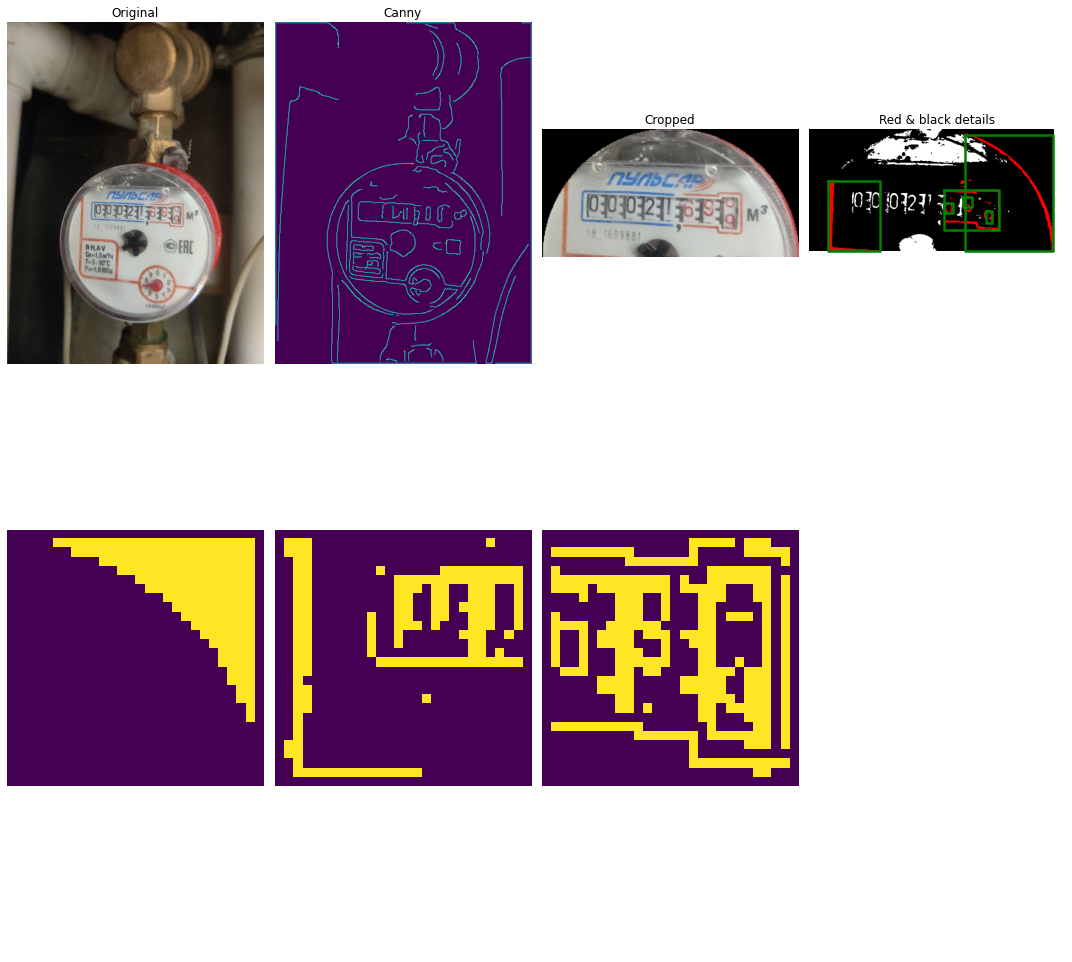

Circle found
Red details found
Black details found


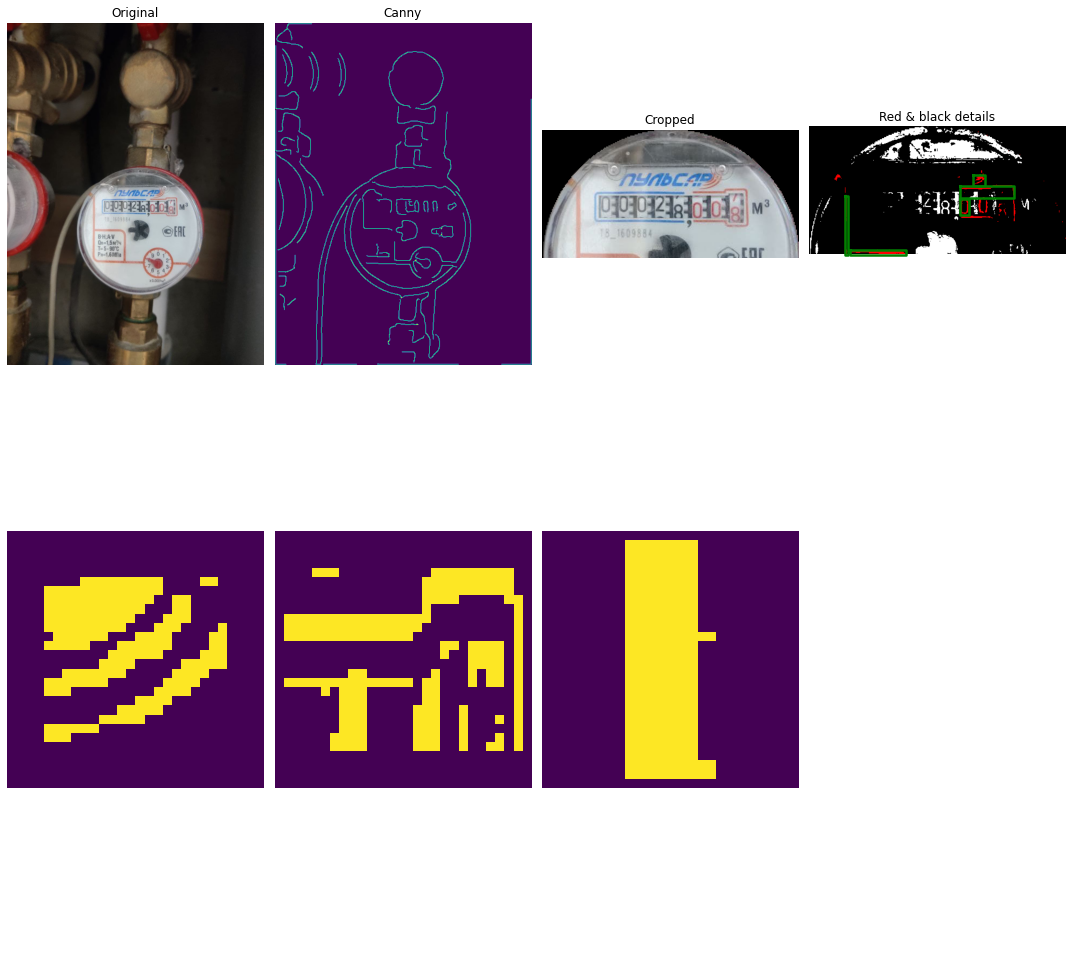

Circle found
Red details found
Black details found


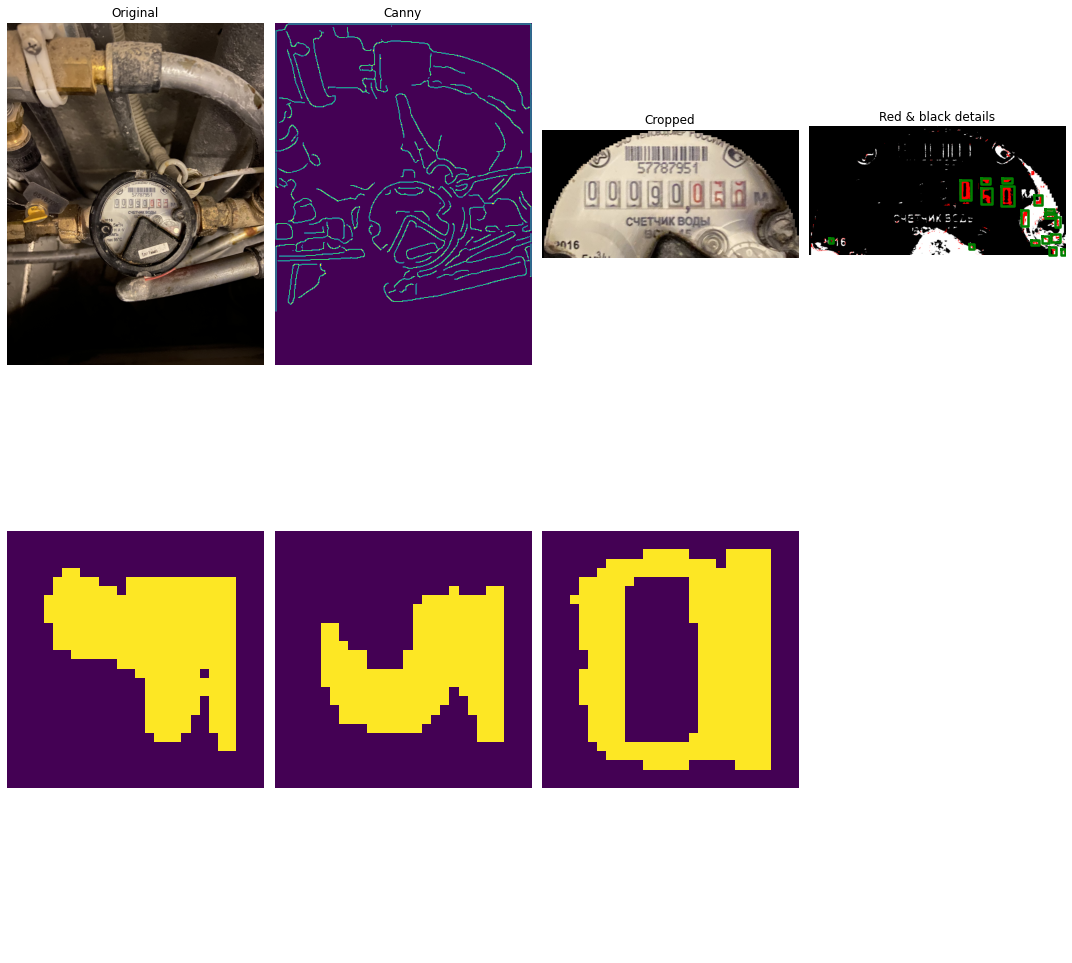

Circle found
Red details found
Black details found


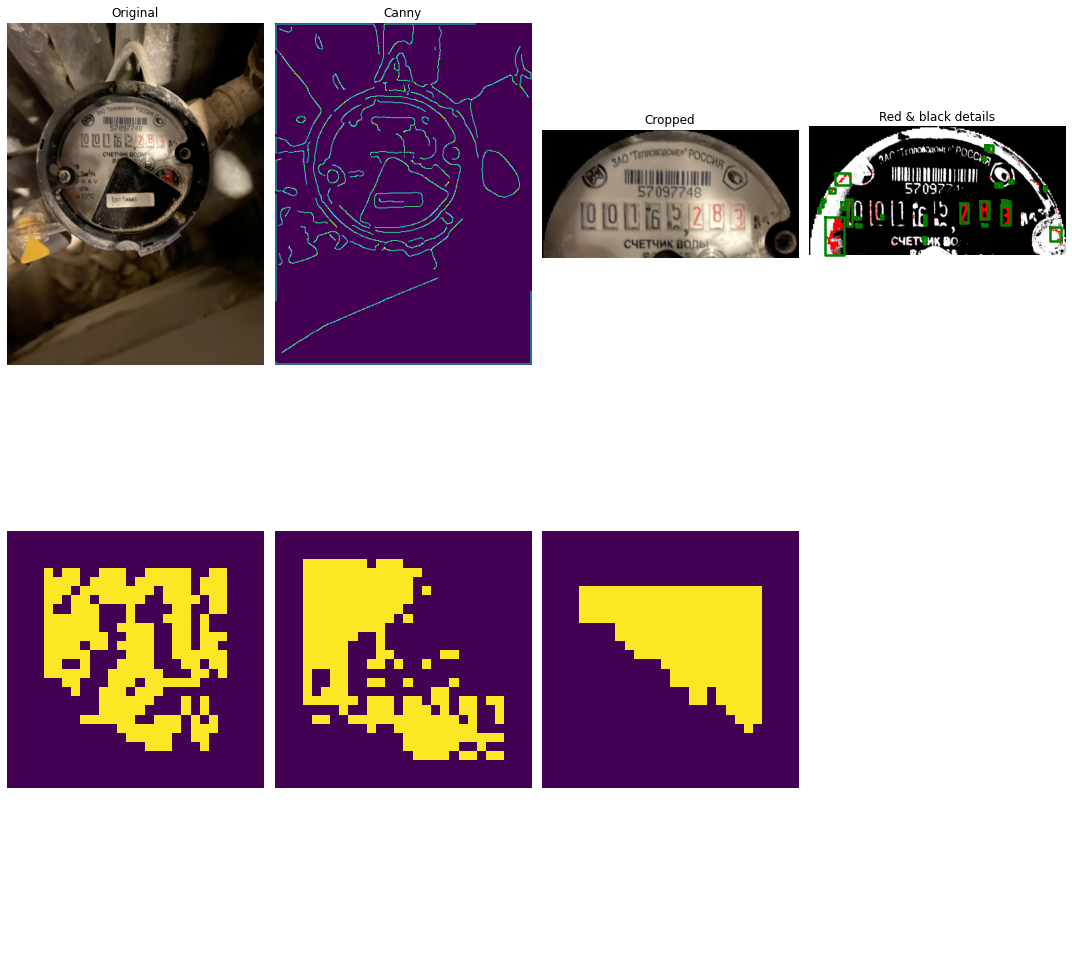

Circle found
Red details found
Black details found


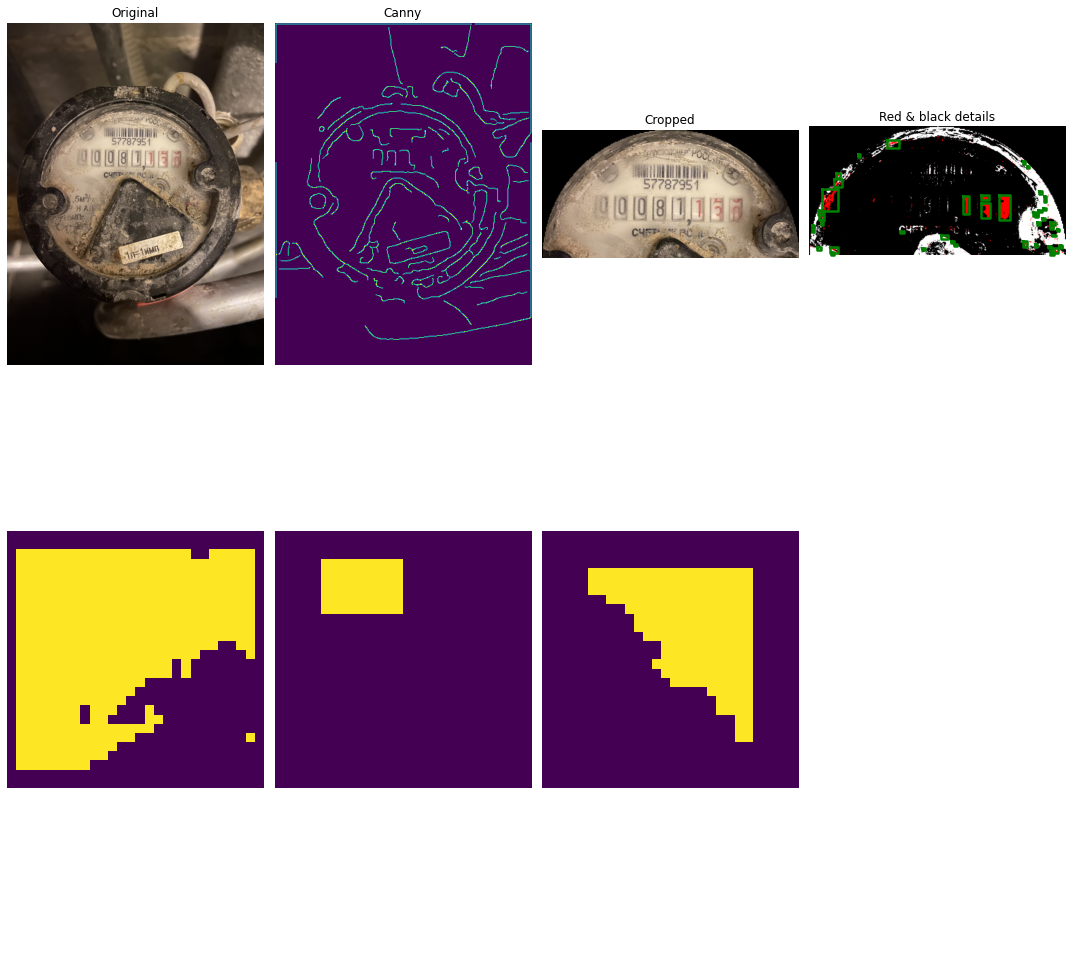

Circle found
Red details found
Black details found


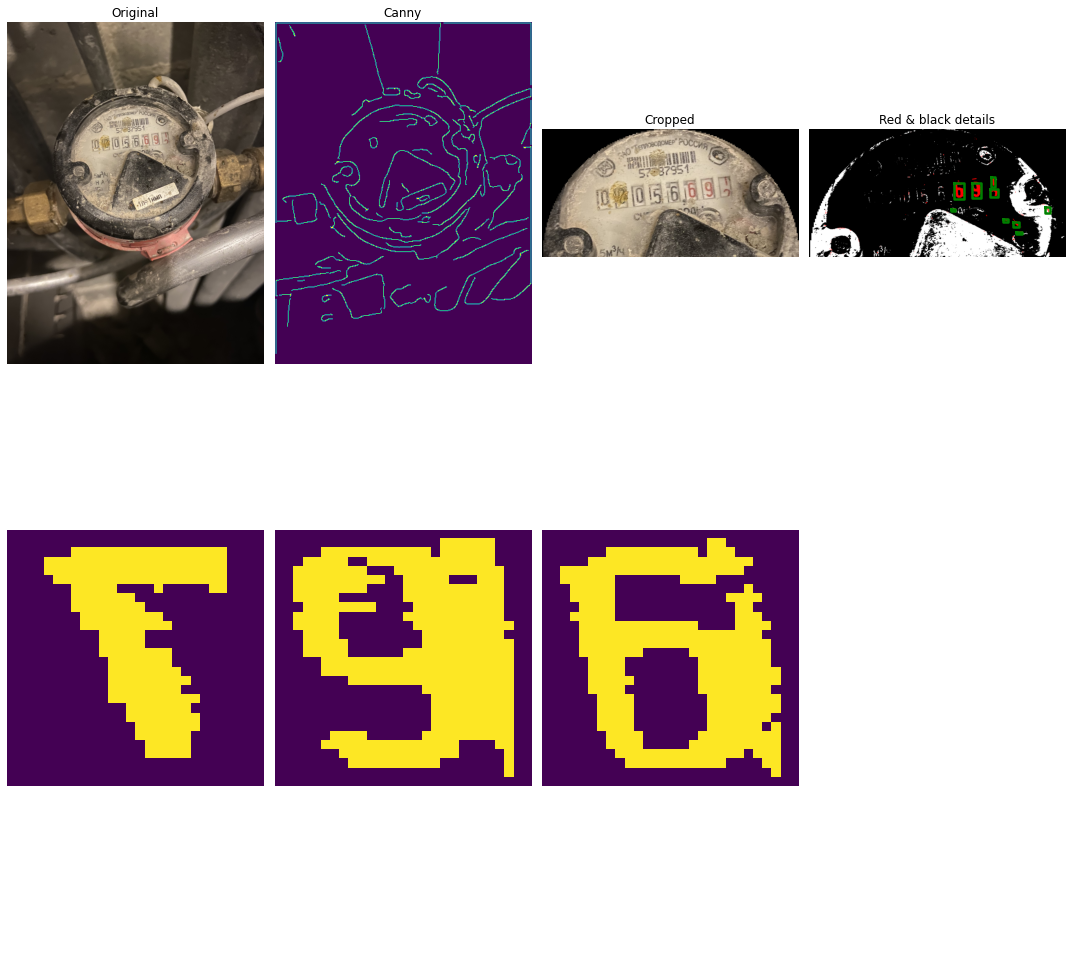

Circle found
Red details found
Black details found


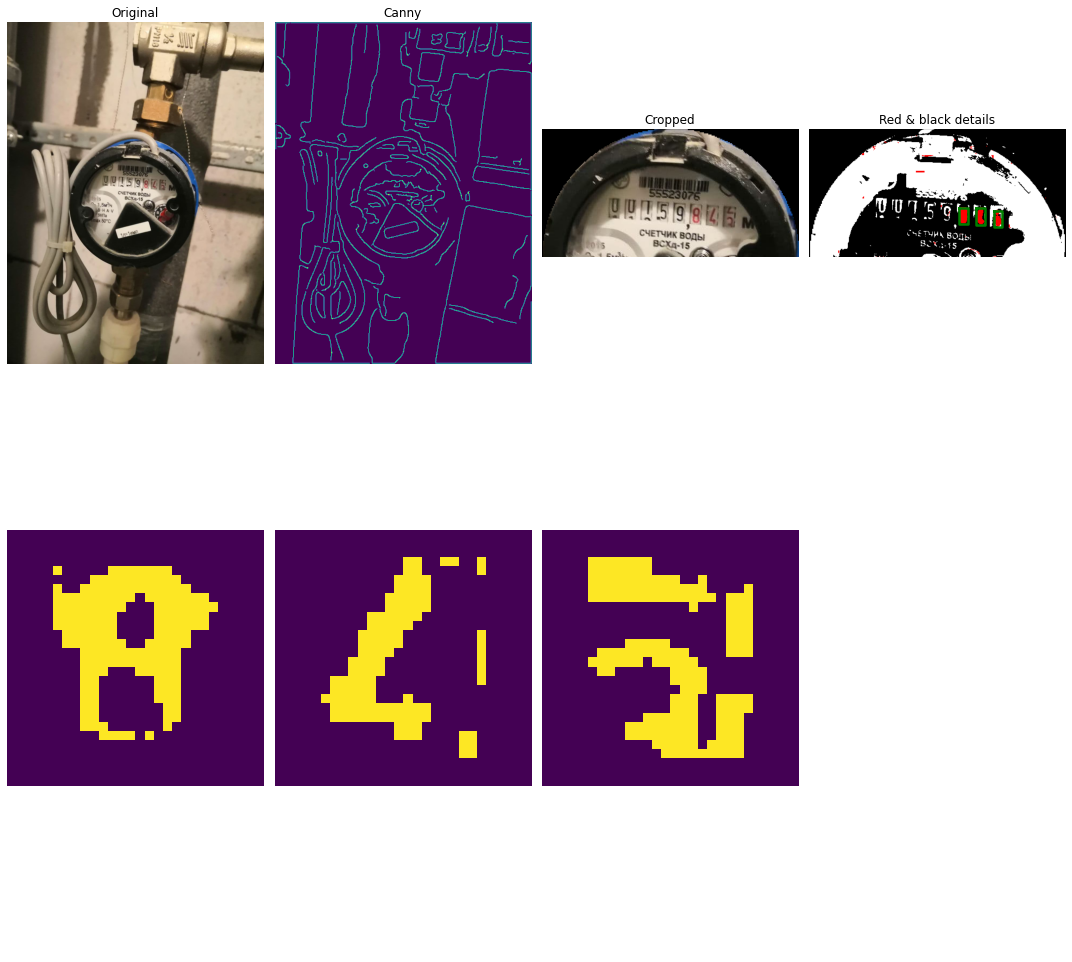

Circle found
Red details found
Black details found


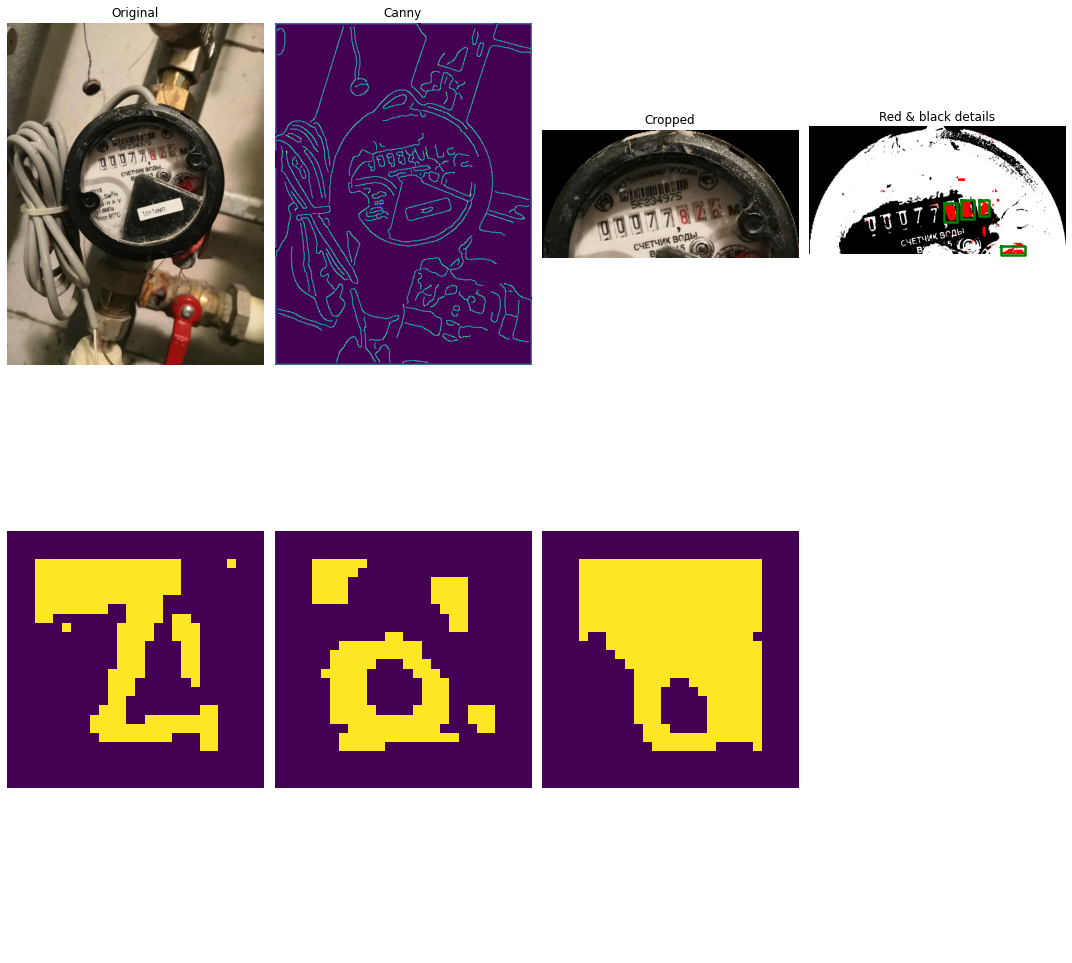

Circle found
Red details found
Black details found


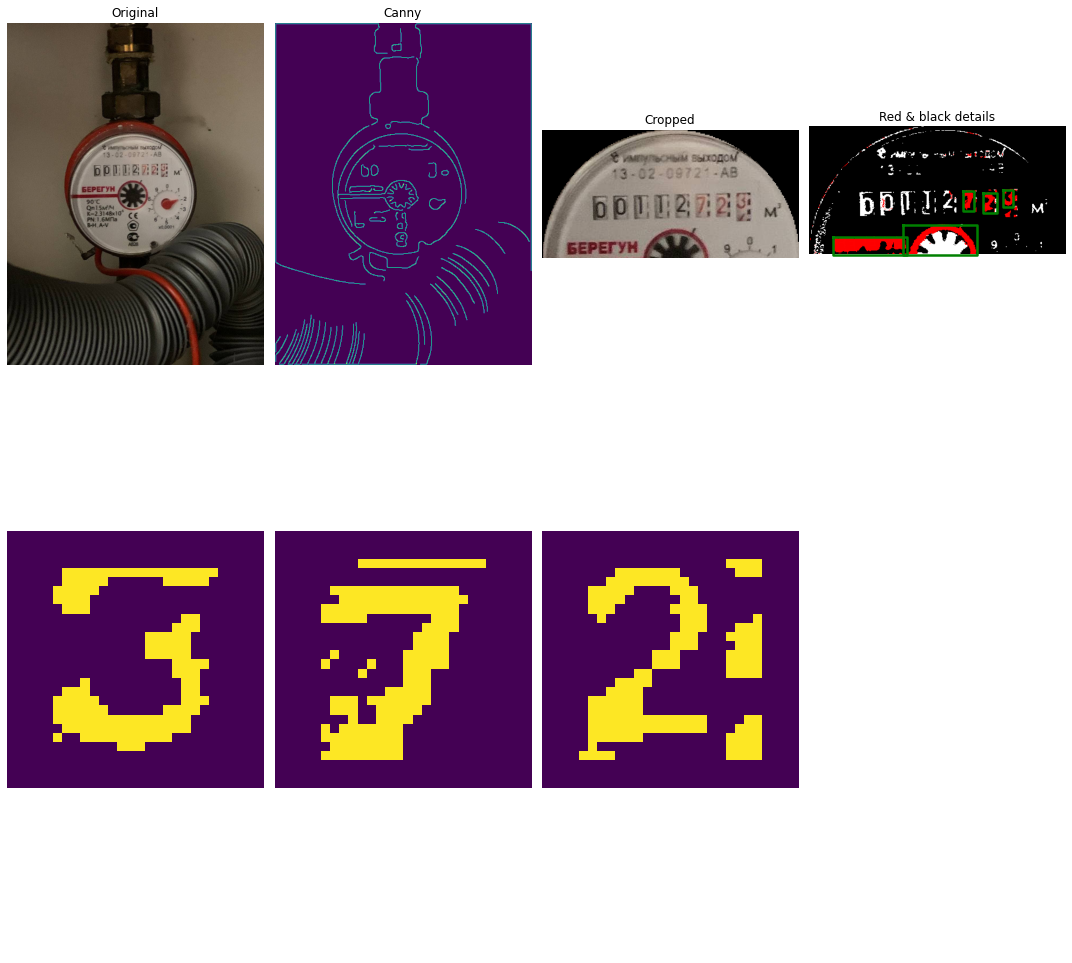

Circle found
Red details found
Black details found


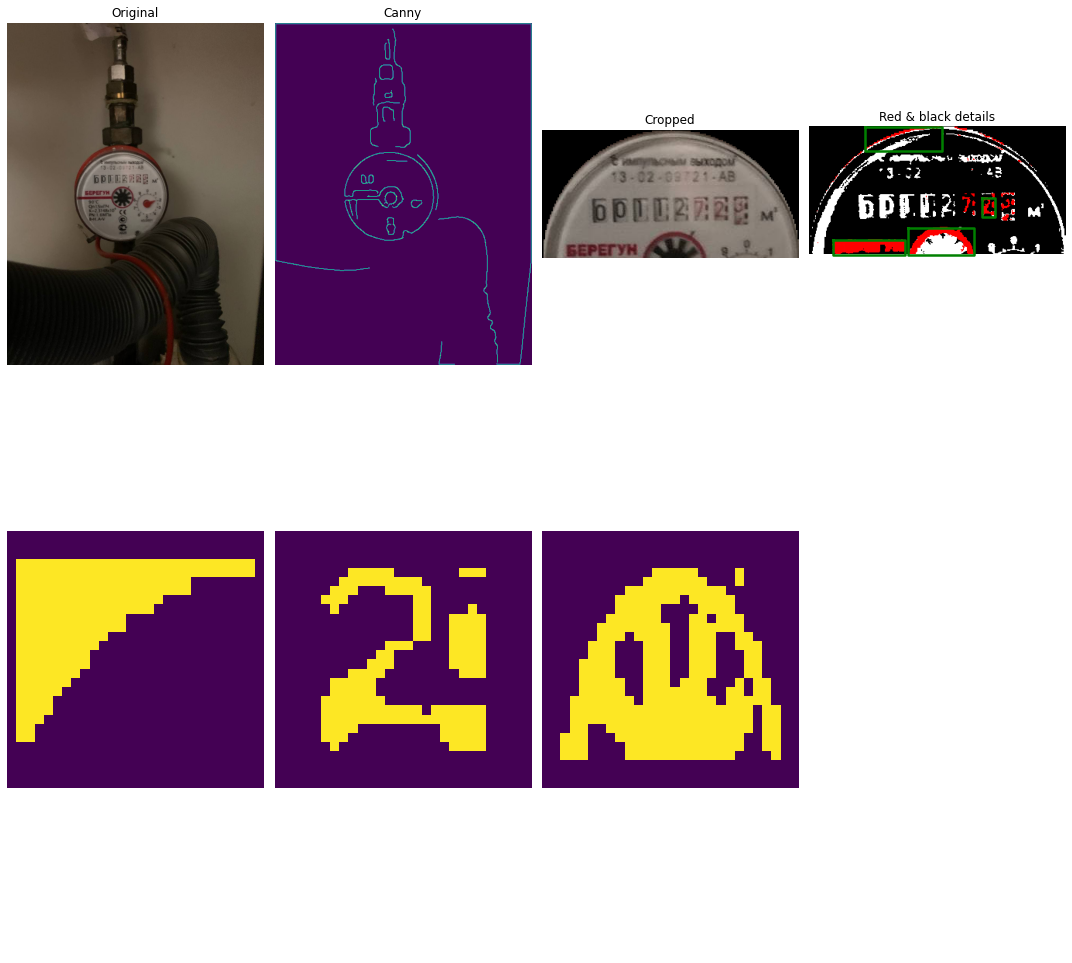

Circle found
Red details found
Black details found


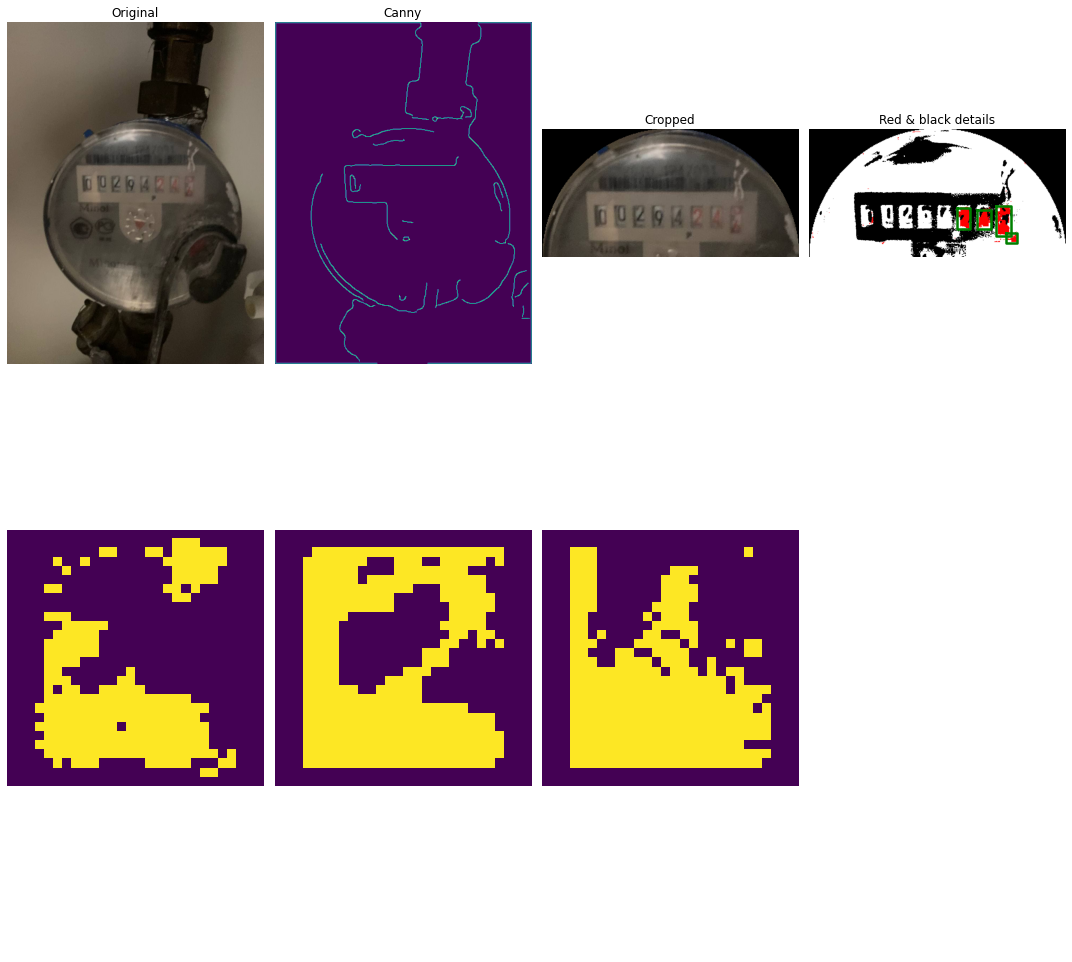

Circle found
Red details found
Black details found


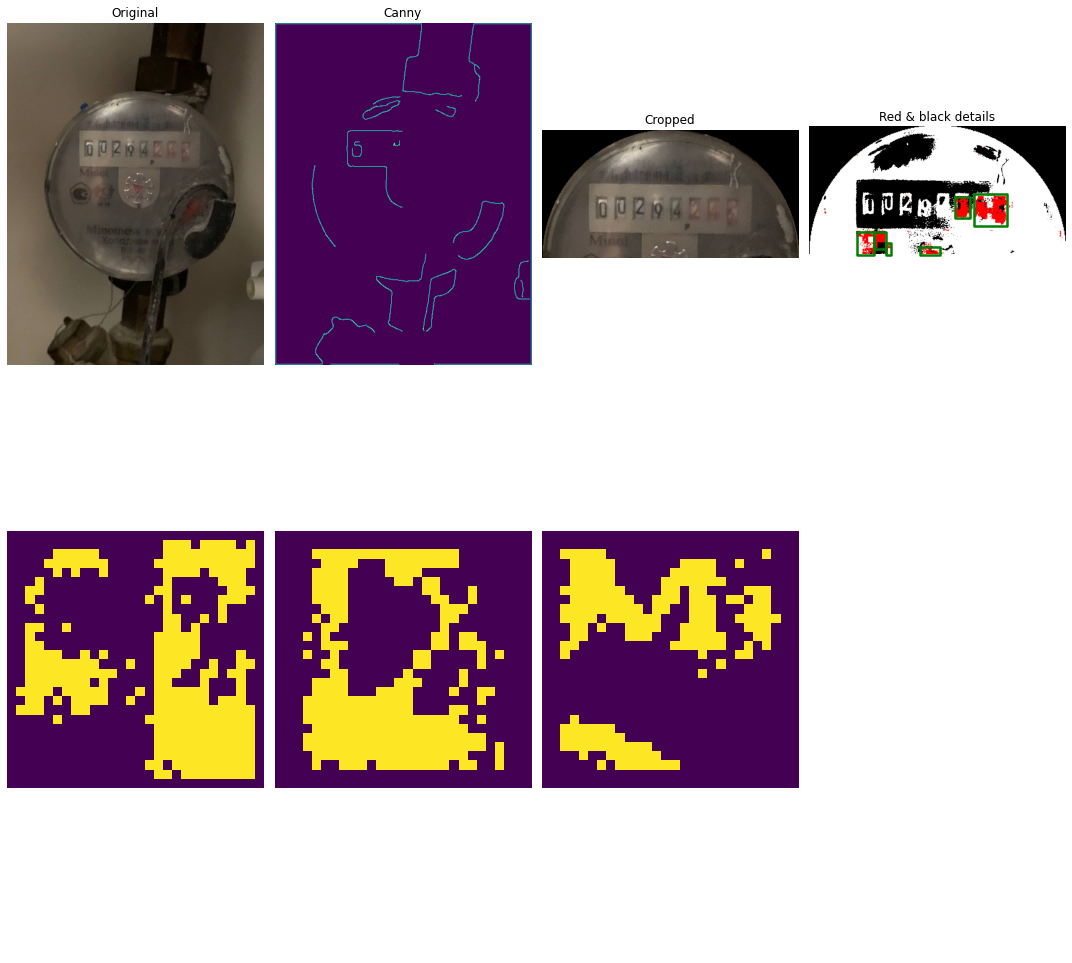

Circle found
Red details found
Black details found


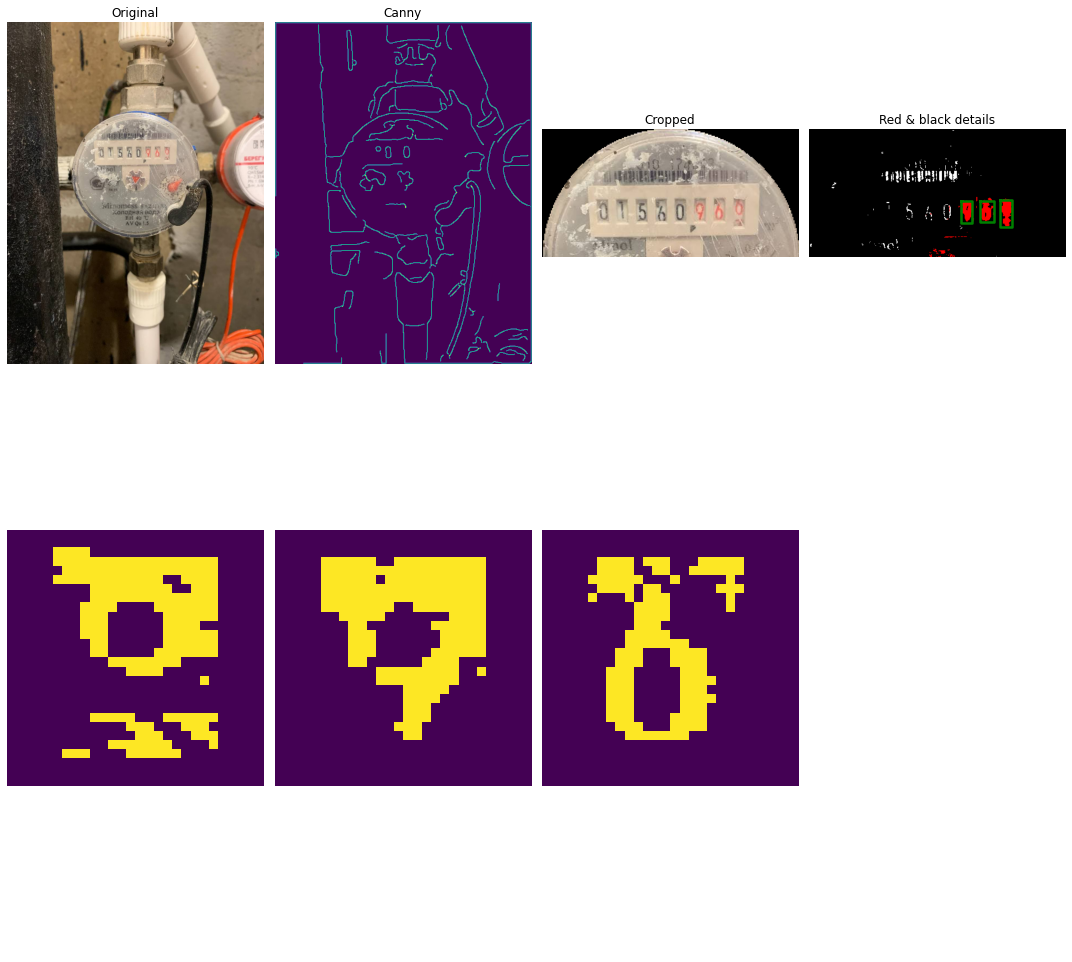

Circle found
Red details found
Black details found


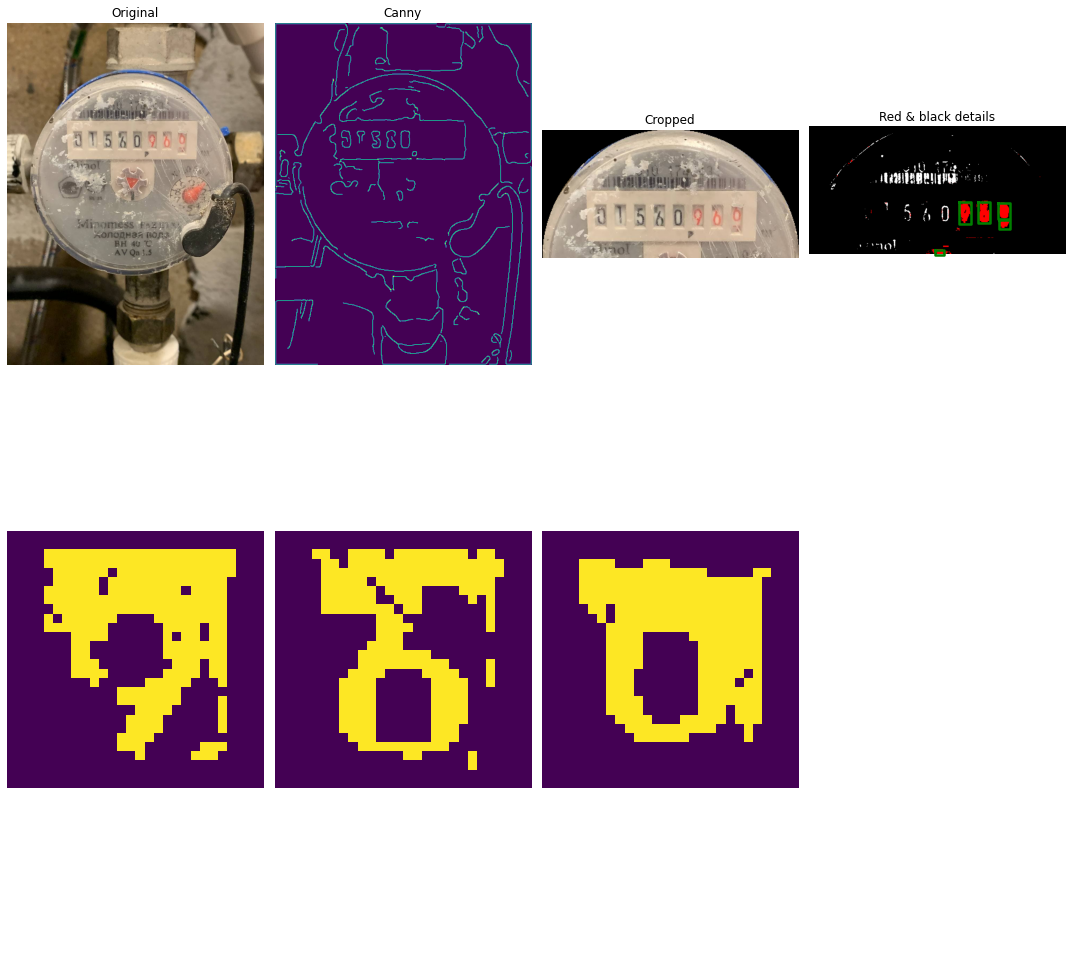

Circle found
Red details found
Black details found


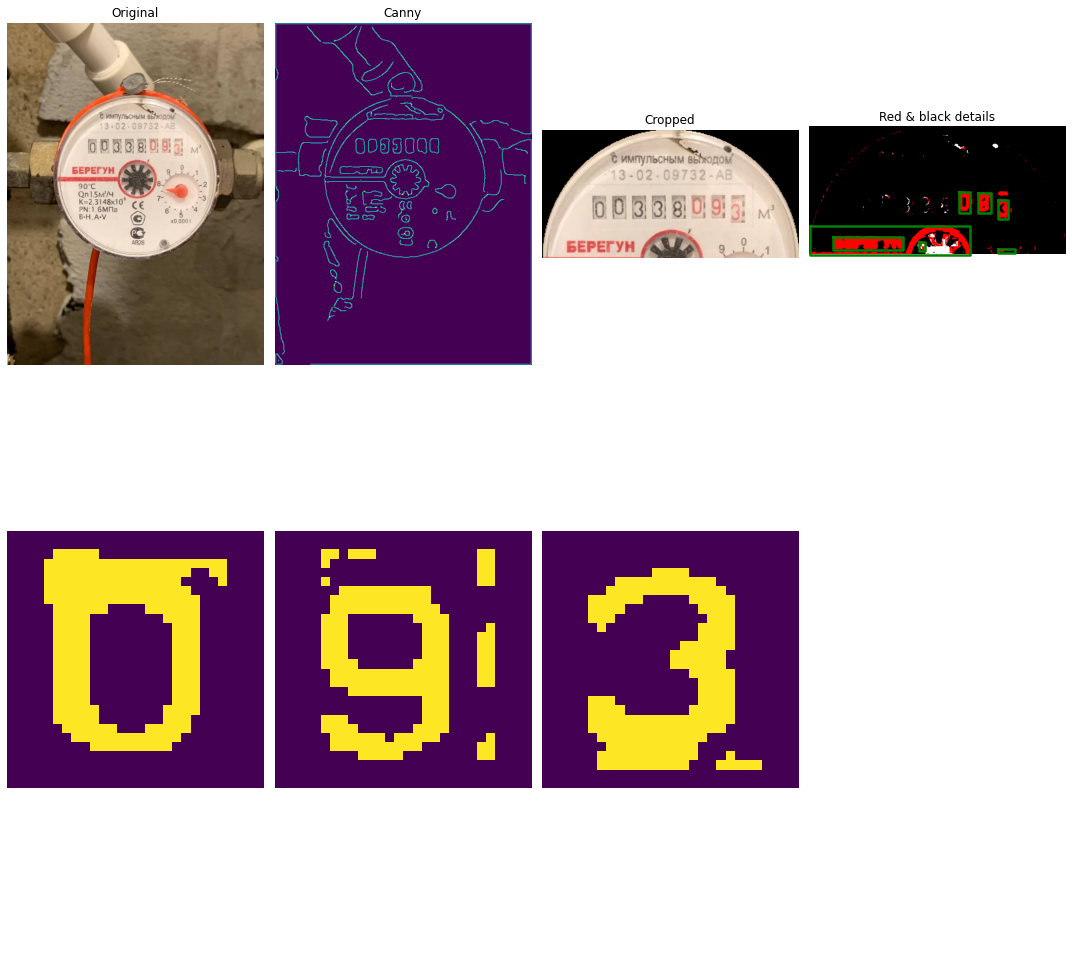

Circle found
Red details found
Black details found


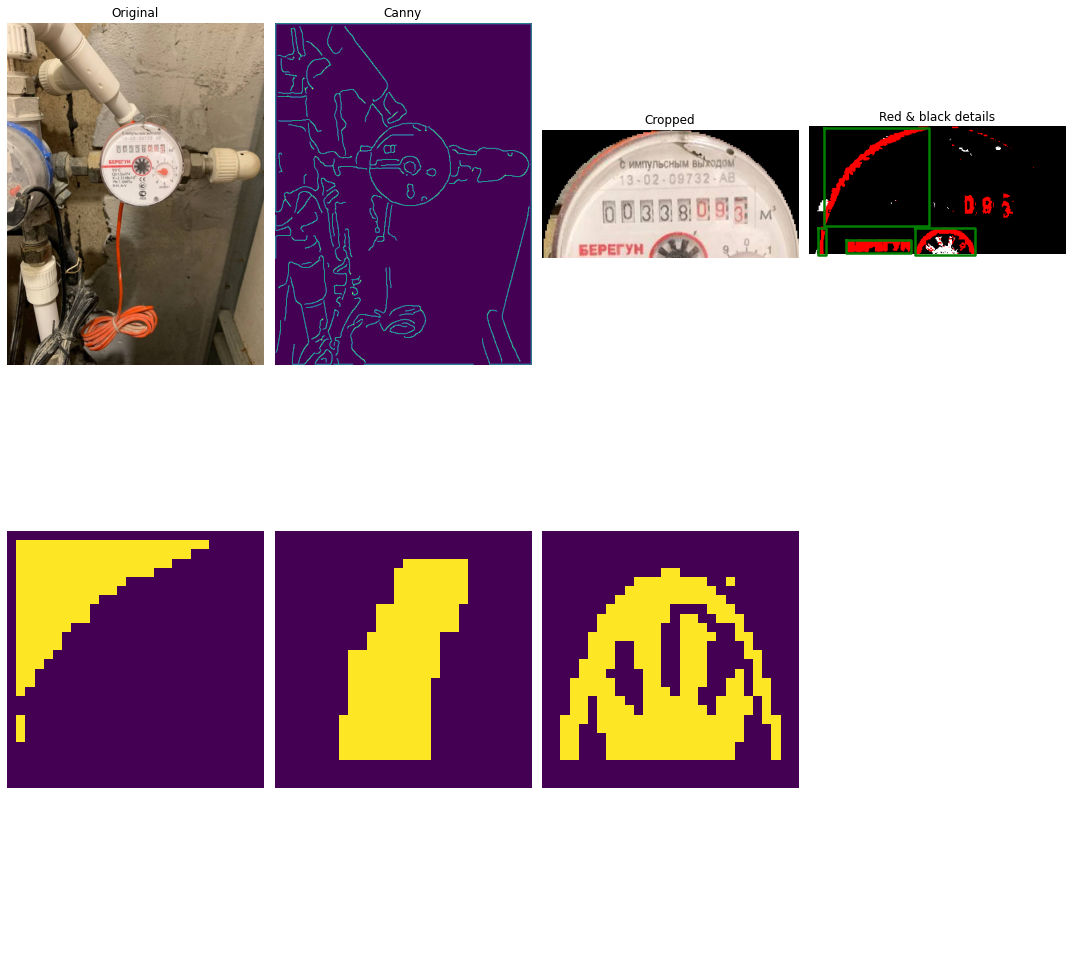

Circle found
Red details found
Black details found


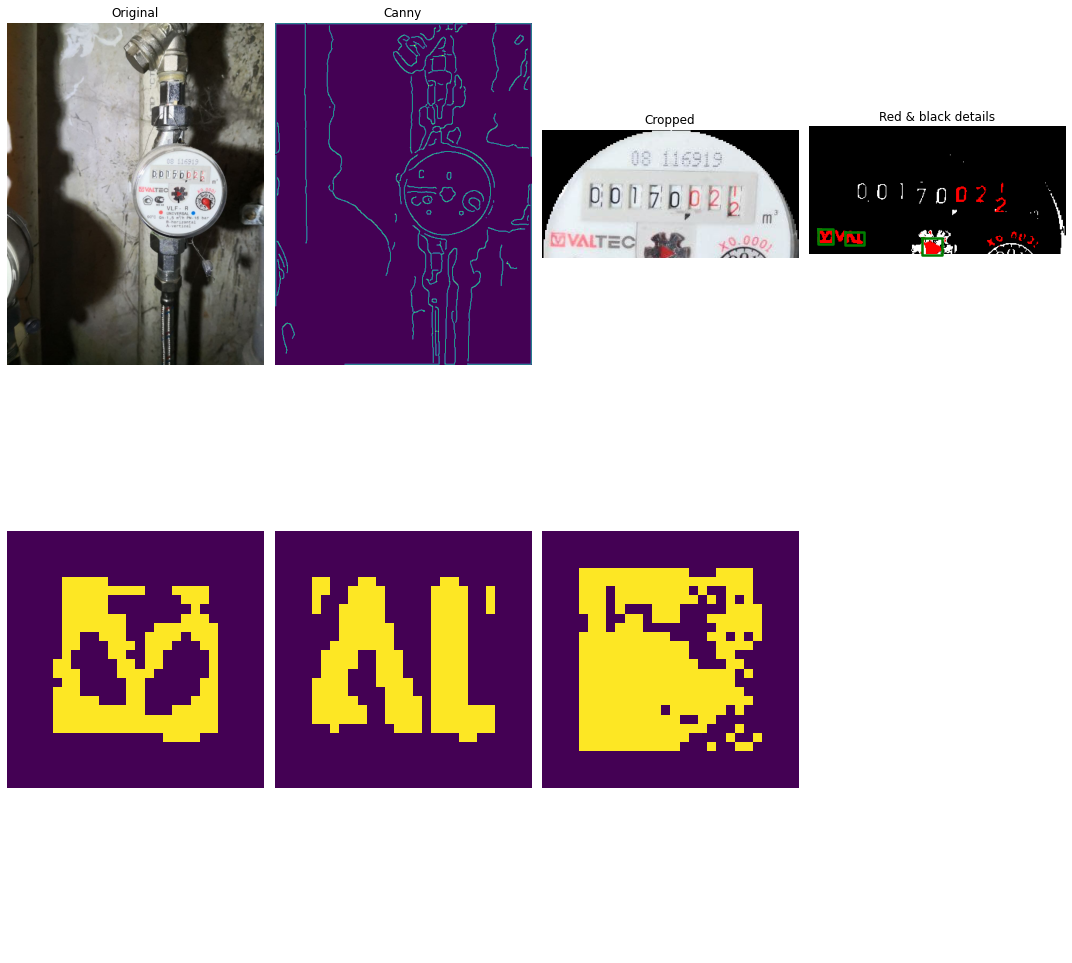

Circle found
Red details found
Black details found


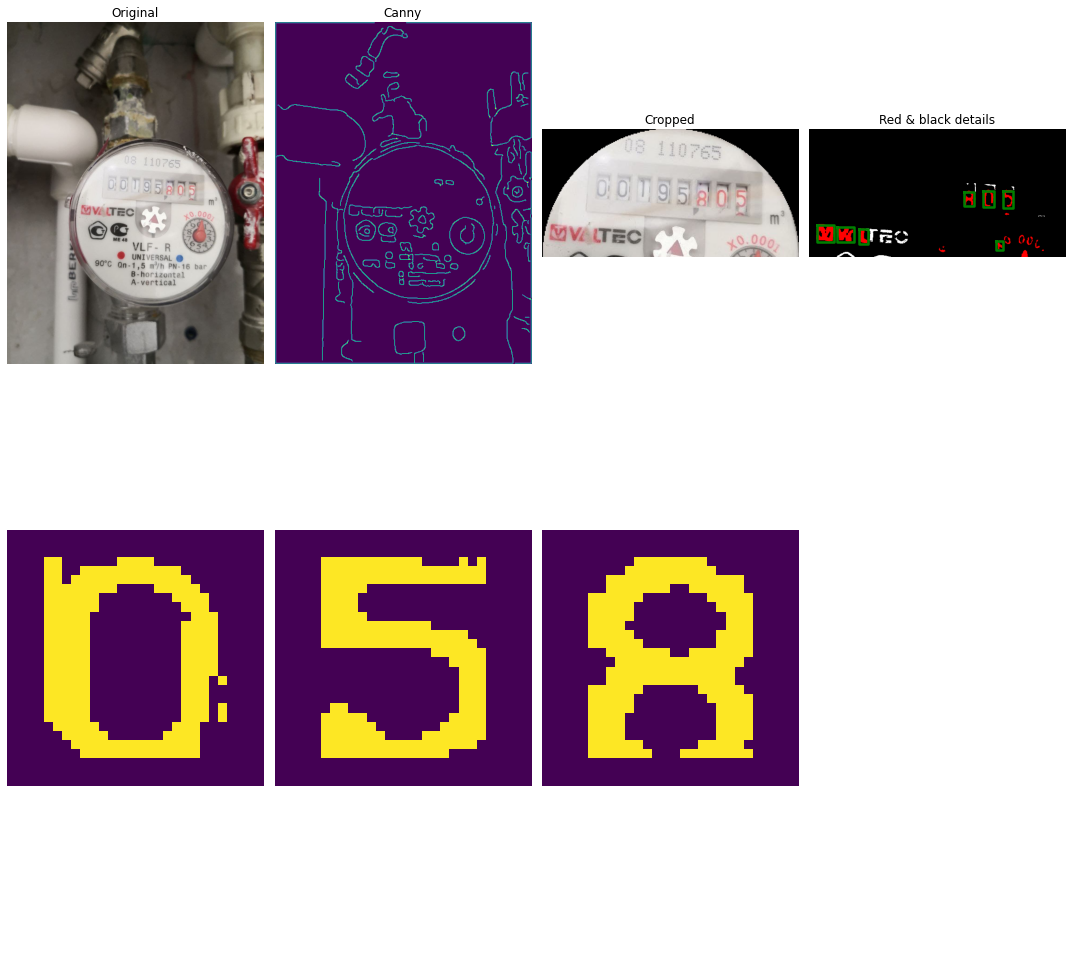

Circle found
Red details found
Black details found


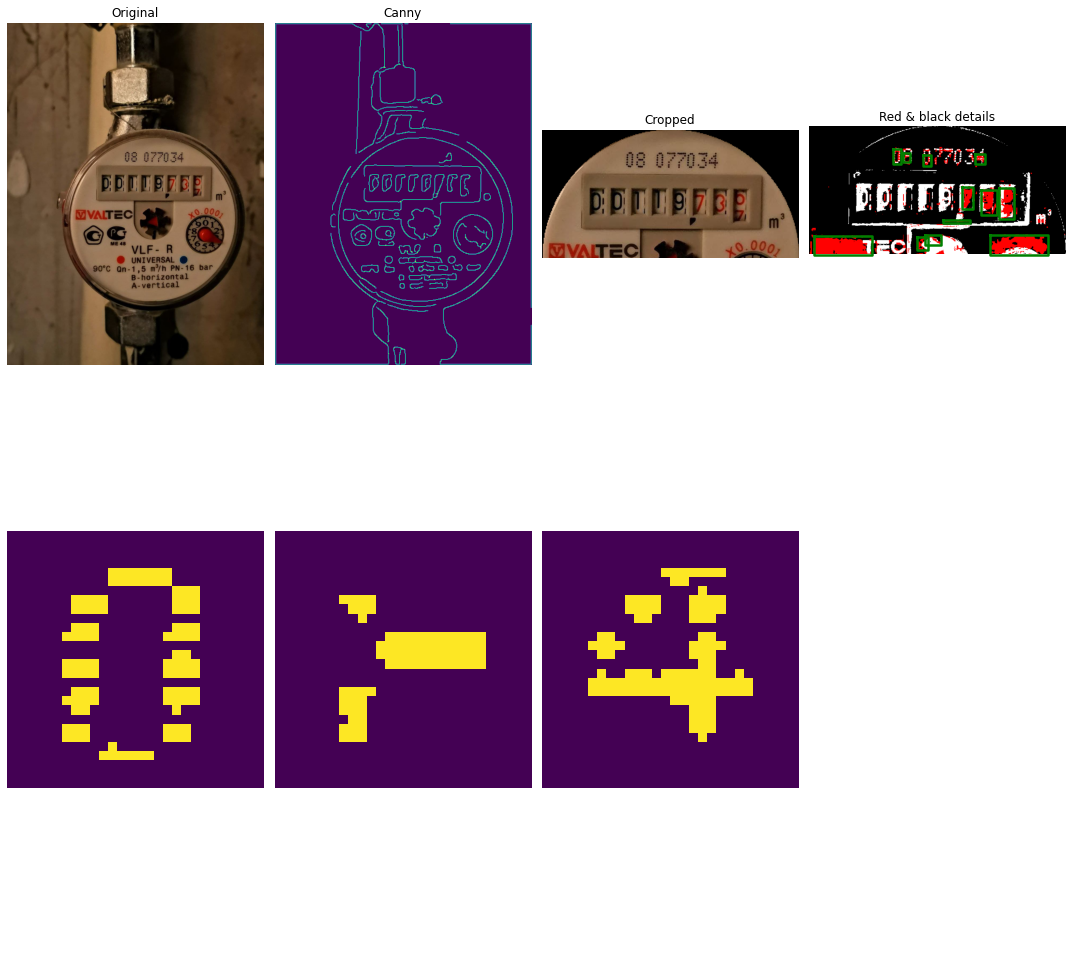

Circle found
Red details found
Black details found


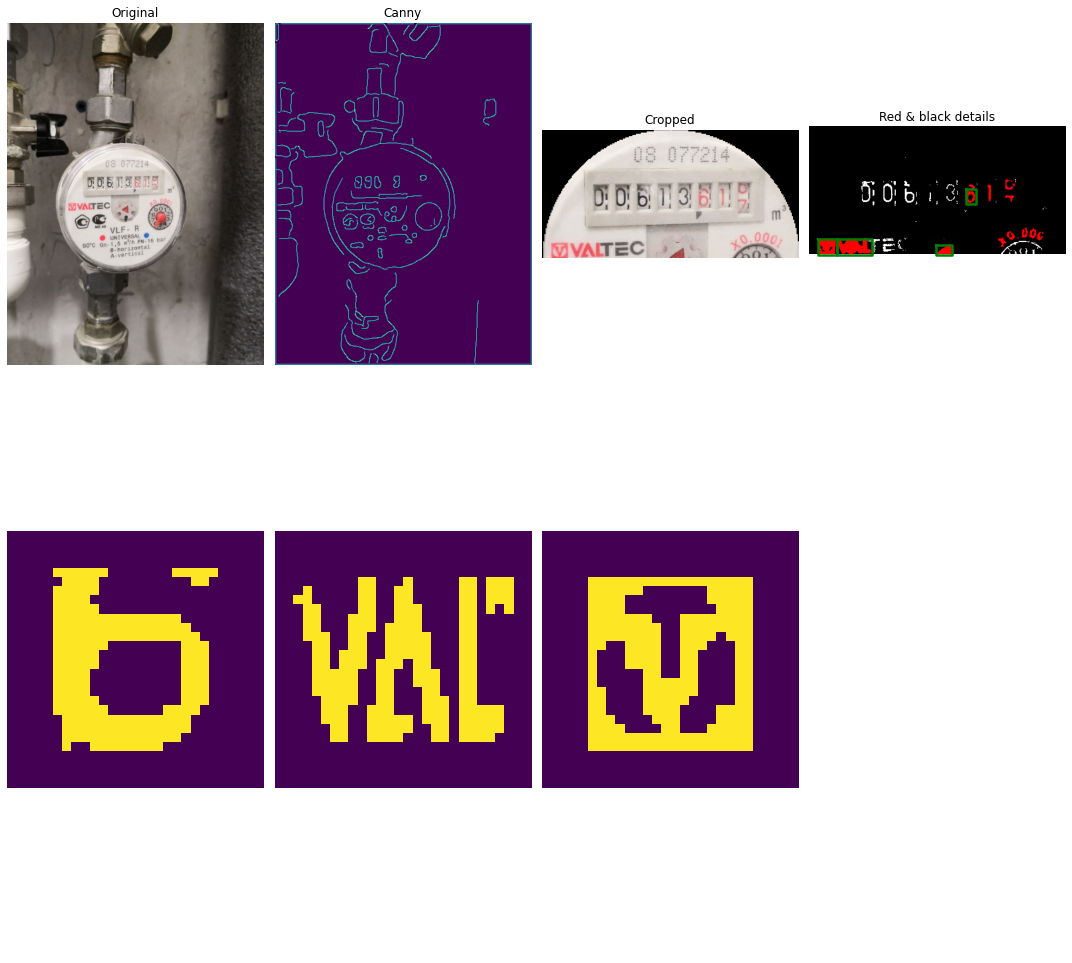

In [18]:
for i in range(1,21):
    detector = MeterDetection(f'Train/{i}.jpg')
    detector.predict(model=model_m)
    detector.plot_all_steps()

In [ ]:
#Looking for red and black regions

def find_color(h_low, h_high, s_low, s_high, v_low, v_high): 
    mask = cv2.inRange(img, (h_low, s_low, v_low), (h_high, s_high, v_high))
    img_ = (rgb2gray(cv2.bitwise_and(img, img, mask=mask))>0).astype(np.uint8) 
    plt.imshow(img_)
    plt.show()


detector = MeterDetection(f'Train/{8}.jpg')
detector.predict(model=model)
img = cv2.cvtColor(detector.circle, cv2.COLOR_BGR2HSV)
#  (108,80,75), (179,255,255)


interact(find_color, h_low=FloatSlider(min=0, max=180, step=1),
                     h_high=FloatSlider(min=0, max=180, step=1),
                     s_low=FloatSlider(min=0, max=255, step=1),
                     s_high=FloatSlider(min=0, max=255, step=1),
                     v_low=FloatSlider(min=0, max=255, step=1),
                     v_high=FloatSlider(min=0, max=255, step=1));

### For presentation

In [ ]:
#picture for presentation

nrow = 4
ncol = 5

fig = plt.figure(figsize=(20,16)) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

q=1
for i in range(nrow):
    for j in range(ncol):
        img = io.imread(f'Train/{q}.jpg')
        ax=plt.subplot(gs[i,j])
        ax.imshow(img)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        q+=1
plt.savefig('train_data.jpg')
plt.show()

### Making templates

In [8]:

detector = MeterDetection(f'Train/2.jpg')
detector.predict(model=model_m)

im = Image.fromarray(detector.circle)
im.save('Templates/model2.png')

Circle found
Red details found
Black details found


In [ ]:
detector = MeterDetection(f'Train/15.jpg')
detector.predict(model=model_m)

im = Image.fromarray(detector.circle)
im.save('Templates/model0.png')

In [9]:
detector = MeterDetection(f'Train/3.jpg')
detector.predict(model=model_m)

im = Image.fromarray(detector.circle)
im.save('Templates/model3.png')

Circle found
Red details found
Black details found


In [10]:
detector = MeterDetection(f'Train/13.jpg')
detector.predict(model=model_m)

im = Image.fromarray(detector.circle)
im.save('Templates/model4.png')

Circle found
Red details found
Black details found


In [11]:
detector = MeterDetection(f'Train/17.jpg')
detector.predict(model=model_m)

im = Image.fromarray(detector.circle)
im.save('Templates/model5.png')

Circle found
Red details found
Black details found
